# Data Loading and Initial Processing

In [5]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),
    ('order_items.csv', 'order_items')
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='Ethics@1996',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = '/Users/vivekkumar/Desktop/Project/Dataset'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

In [208]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector


db = mysql.connector.connect(host = "localhost",
                            username = "root",
                            password = "Ethics@1996",
                            database = "ecommerce")

cur = db.cursor()

# Exploratory Analysis
# 1. List all unique cities where customers are located. 

In [11]:
query = """ select distinct customer_city from customers """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data)
df.head()

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# 2. Count the number of orders placed in 2017. 

In [13]:
query = """ select count(order_id) from orders where year(order_purchase_timestamp) = 2017 """

cur.execute(query)

data = cur.fetchall()

"total orders placed in 2017 are", data[0][0]

('total orders placed in 2017 are', 45101)

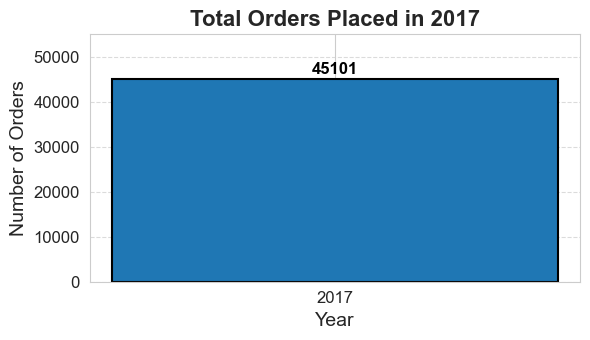

In [157]:
import matplotlib.pyplot as plt

year = '2017'
total_orders = 45101 

# Create a bar chart
plt.figure(figsize=(6, 3.5))
bars = plt.bar(year, total_orders, color='#1f77b4', edgecolor='black', linewidth=1.5)

plt.title('Total Orders Placed in 2017', fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Orders', fontsize=14)

plt.text(year, total_orders + 500, str(total_orders), ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.ylim(0, total_orders + 10000)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()




# 3. Find the total sales per category. 

In [15]:
query = """ select upper(products.product_category) category, 
round(sum(payments.payment_value),2) sales
from products join order_items 
on products.product_id = order_items.product_id
join payments 
on payments.order_id = order_items.order_id
group by category
"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["Category", "Sales"])
df

,Category,Sales
0,PERFUMERY,506738.66
1,FURNITURE DECORATION,1430176.39
2,TELEPHONY,486882.05
3,BED TABLE BATH,1712553.67
4,AUTOMOTIVE,852294.33
...,...,...
69,CDS MUSIC DVDS,1199.43
70,LA CUISINE,2913.53
71,FASHION CHILDREN'S CLOTHING,785.67
72,PC GAMER,2174.43


# 4. Calculate the percentage of orders that were paid in installments. 

In [113]:
# Taking order into consideration excluding single payment installments 
query = """ select ((sum(case when payment_installments > 1 then 1
else 0 end))/count(*))*100 from payments
"""

cur.execute(query)

data = cur.fetchall()

"the percentage of orders that were paid in installments is", data[0][0]

('the percentage of orders that were paid in installments is',
 Decimal('49.4176'))

In [221]:
#Taking order into consideration including single payment installments 

query = """ select ((sum(case when payment_installments >= 1 then 1
else 0 end))/count(*))*100 from payments
"""

cur.execute(query)

data = cur.fetchall()

"the percentage of orders that were paid in installments is", data[0][0]




('the percentage of orders that were paid in installments is',
 Decimal('99.9981'))

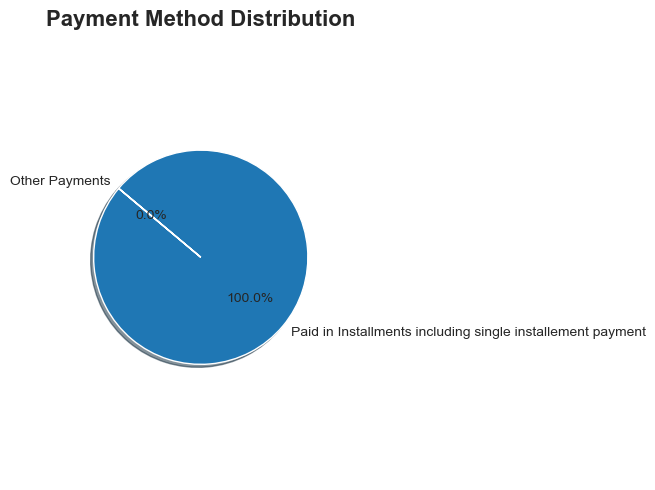

In [231]:
import matplotlib.pyplot as plt

# Data for visualization
percentage_paid_in_installments = data[0][0]  # Replace with the actual percentage value from your query
percentage_other = 100 - percentage_paid_in_installments  # Remaining percentage

labels = ['Paid in Installments including single installement payment', 'Other Payments']
sizes = [percentage_paid_in_installments, percentage_other]
colors = ['#1f77b4', '#aec7e8']  # Blue color palette

plt.figure(figsize=(6, 5))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140, shadow=True)

plt.title('Payment Method Distribution', fontsize=16, fontweight='bold')
plt.axis('equal')

plt.tight_layout()
plt.show()



# 5. Count the number of customers from each state. 

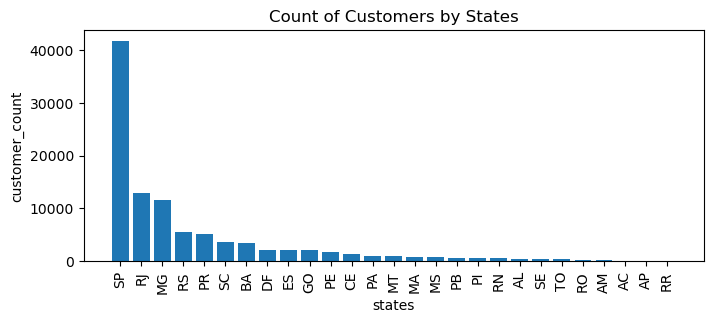

In [19]:
query = """ select customer_state ,count(customer_id)
from customers group by customer_state
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["state", "customer_count" ])
df = df.sort_values(by = "customer_count", ascending= False)

plt.figure(figsize = (8,3))
plt.bar(df["state"], df["customer_count"])
plt.xticks(rotation = 90)
plt.xlabel("states")
plt.ylabel("customer_count")
plt.title("Count of Customers by States")
plt.show()

# Intermediate Queries (Deeper Insights)
# 1. Calculate the number of orders per month in 2018.

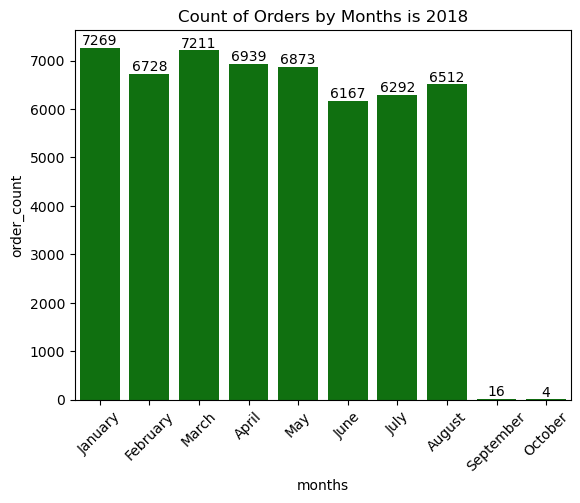

In [23]:
query = """ select monthname(order_purchase_timestamp) months, count(order_id) order_count
from orders where year(order_purchase_timestamp) = 2018
group by months
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["months", "order_count"])
o = ["January", "February","March","April","May","June","July","August","September","October"]

ax = sns.barplot(x = df["months"],y =  df["order_count"], data = df, order = o, color = "green")
plt.xticks(rotation = 45)
ax.bar_label(ax.containers[0])
plt.title("Count of Orders by Months is 2018")

plt.show()

# 2. Find the average number of products per order, grouped by customer city. 

In [184]:
query = """with count_per_order as 
(select orders.order_id, orders.customer_id, count(order_items.order_id) as oc
from orders join order_items
on orders.order_id = order_items.order_id
group by orders.order_id, orders.customer_id)

select customers.customer_city, round(avg(count_per_order.oc),2) average_orders
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city order by average_orders desc
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data,columns = ["customer city", "average products/order"])
df.head(20)


,customer city,average products/order
0,padre carvalho,7.00
1,celso ramos,6.50
2,datas,6.00
3,candido godoi,6.00
4,matias olimpio,5.00
5,cidelandia,4.00
6,picarra,4.00
7,morro de sao paulo,4.00
8,teixeira soares,4.00
9,curralinho,4.00


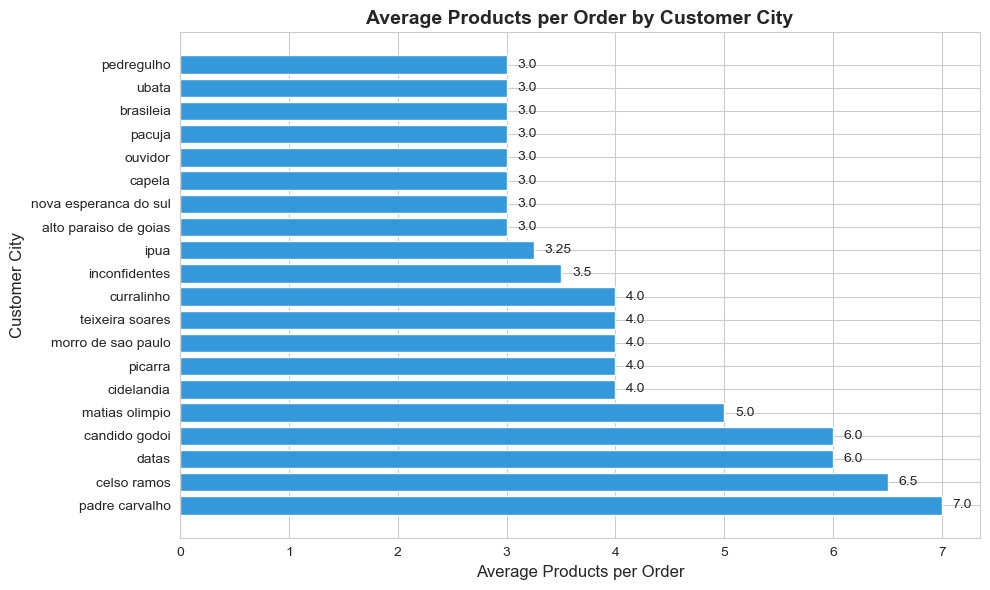

In [190]:
import matplotlib.pyplot as plt
import pandas as pd

data = [
    ('padre carvalho', 7.00),
    ('celso ramos', 6.50),
    ('datas', 6.00),
    ('candido godoi', 6.00),
    ('matias olimpio', 5.00),
    ('cidelandia', 4.00),
    ('picarra', 4.00),
    ('morro de sao paulo', 4.00),
    ('teixeira soares', 4.00),
    ('curralinho', 4.00),
    ('inconfidentes', 3.50),
    ('ipua', 3.25),
    ('alto paraiso de goias', 3.00),
    ('nova esperanca do sul', 3.00),
    ('capela', 3.00),
    ('ouvidor', 3.00),
    ('pacuja', 3.00),
    ('brasileia', 3.00),
    ('ubata', 3.00),
    ('pedregulho', 3.00)
]

df = pd.DataFrame(data, columns=["Customer City", "Average Products/Order"])

# Plotting the bar chart for average products per order by city
plt.figure(figsize=(10, 6))
plt.barh(df['Customer City'], df['Average Products/Order'], color='#3498db')

plt.xlabel('Average Products per Order', fontsize=12)
plt.ylabel('Customer City', fontsize=12)
plt.title('Average Products per Order by Customer City', fontsize=14, weight='bold')

for index, value in enumerate(df['Average Products/Order']):
    plt.text(value + 0.1, index, str(value), fontsize=10, va='center')

plt.tight_layout()
plt.show()



# 3. Calculate the percentage of total revenue contributed by each product category.

In [167]:
query = """select upper(products.product_category) category, 
round((sum(payments.payment_value)/(select sum(payment_value) from payments))*100,2) sales_percentage
from products join order_items 
on products.product_id = order_items.product_id
join payments 
on payments.order_id = order_items.order_id
group by category order by sales_percentage desc"""


cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Category", "percentage distribution"])
df.head()

,Category,percentage distribution
0,BED TABLE BATH,10.70
1,HEALTH BEAUTY,10.35
2,COMPUTER ACCESSORIES,9.90
3,FURNITURE DECORATION,8.93
4,WATCHES PRESENT,8.93


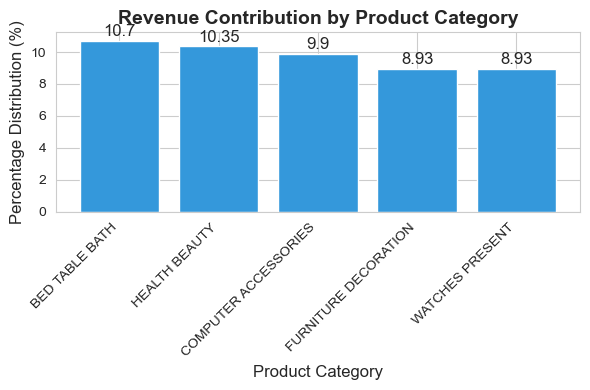

In [163]:
import matplotlib.pyplot as plt
import pandas as pd

data = [
    ('BED TABLE BATH', 10.70),
    ('HEALTH BEAUTY', 10.35),
    ('COMPUTER ACCESSORIES', 9.90),
    ('FURNITURE DECORATION', 8.93),
    ('WATCHES PRESENT', 8.93)
]

df = pd.DataFrame(data, columns=["Category", "percentage distribution"])

# Plotting the bar chart for the percentage distribution by product category
plt.figure(figsize=(6, 4))
plt.bar(df['Category'], df['percentage distribution'], color='#3498db')

plt.xlabel('Product Category', fontsize=12)
plt.ylabel('Percentage Distribution (%)', fontsize=12)
plt.title('Revenue Contribution by Product Category', fontsize=14, weight='bold')

plt.xticks(rotation=45, ha='right')

for i, v in enumerate(df['percentage distribution']):
    plt.text(i, v + 0.3, str(v), ha='center', fontsize=12)

plt.tight_layout()
plt.show()


# 4. Identify the correlation between product price and the number of times a product has been purchased.

In [33]:
import numpy as np

In [39]:
cur = db.cursor()
query = """select products.product_category, 
count(order_items.product_id),
round(avg(order_items.price),2)
from products join order_items
on products.product_id = order_items.product_id
group by products.product_category"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Category", "order_count","price"])

arr1 = df["order_count"]
arr2 = df["price"]

a = np.corrcoef([arr1,arr2])
print("the correlation between price and number of times a product has been purchased is", a[0][-1])

the correlation between price and number of times a product has been purchased is -0.10631514167157562


# 5. Calculate the total revenue generated by each seller, and rank them by revenue.


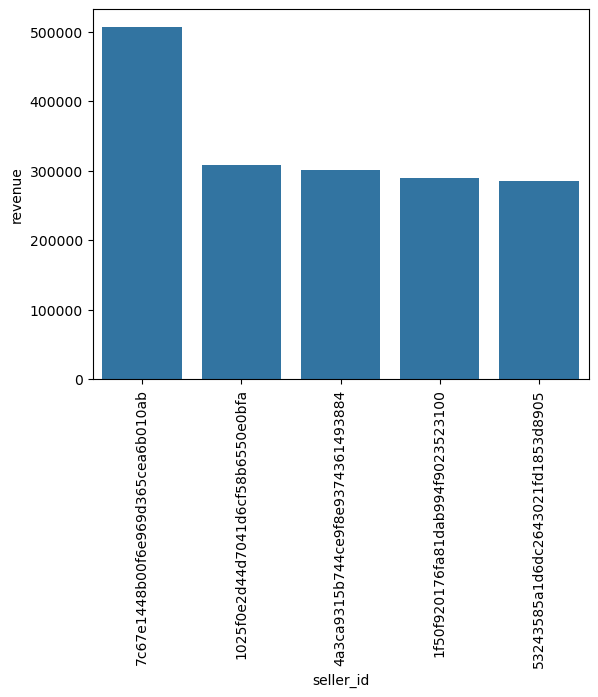

In [37]:
query = """ select *, dense_rank() over(order by revenue desc) as rn from
(select order_items.seller_id, sum(payments.payment_value)
revenue from order_items join payments
on order_items.order_id = payments.order_id
group by order_items.seller_id) as a """

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["seller_id", "revenue", "rank"])
df = df.head()
sns.barplot(x = "seller_id", y = "revenue", data = df)
plt.xticks(rotation = 90)
plt.show()

# Advanced Queries (Predictive Analytics)
# 1. Calculate the moving average of order values for each customer over their order history. 

In [41]:
query = """select customer_id, order_purchase_timestamp, payment,
avg(payment) over(partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as mov_avg
from
(select orders.customer_id, orders.order_purchase_timestamp, 
payments.payment_value as payment
from payments join orders
on payments.order_id = orders.order_id) as a"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df

,0,1,2,3
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002
...,...,...,...,...
103881,fffecc9f79fd8c764f843e9951b11341,2018-03-29 16:59:26,0.64,27.120001
103882,fffeda5b6d849fbd39689bb92087f431,2018-05-22 13:36:02,63.13,63.130001
103883,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,214.13,214.130005
103884,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000


# 2. Calculate the cumulative sales per month for each year.

In [43]:
query = """select years, months , payment, sum(payment)
over(order by years, months) cumulative_sales from 
(select year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years, months order by years, months) as a
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df

,0,1,2,3
0,2016,9,252.24,252.24
1,2016,10,59090.48,59342.72
2,2016,12,19.62,59362.34
3,2017,1,138488.04,197850.38
4,2017,2,291908.01,489758.39
5,2017,3,449863.60,939621.99
6,2017,4,417788.03,1357410.02
7,2017,5,592918.82,1950328.84
8,2017,6,511276.38,2461605.22
9,2017,7,592382.92,3053988.14


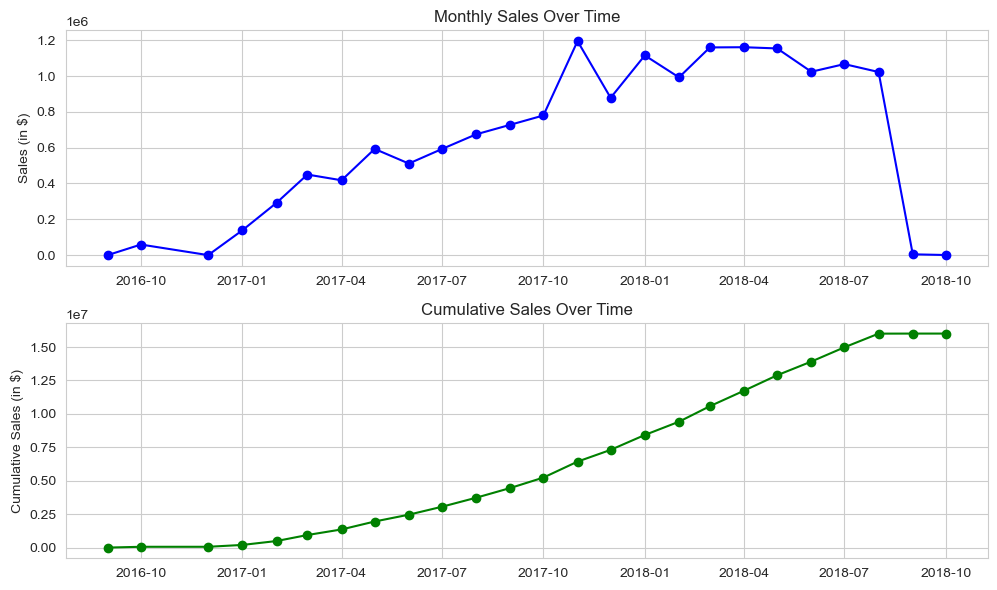

In [198]:
import matplotlib.pyplot as plt
import pandas as pd

data = [
    (2016, 9, 252.24, 252.24),
    (2016, 10, 59090.48, 59342.72),
    (2016, 12, 19.62, 59362.34),
    (2017, 1, 138488.04, 197850.38),
    (2017, 2, 291908.01, 489758.39),
    (2017, 3, 449863.60, 939621.99),
    (2017, 4, 417788.03, 1357410.02),
    (2017, 5, 592918.82, 1950328.84),
    (2017, 6, 511276.38, 2461605.22),
    (2017, 7, 592382.92, 3053988.14),
    (2017, 8, 674396.32, 3728384.46),
    (2017, 9, 727762.45, 4456146.91),
    (2017, 10, 779677.88, 5235824.79),
    (2017, 11, 1194882.80, 6430707.59),
    (2017, 12, 878401.48, 7309109.07),
    (2018, 1, 1115004.18, 8424113.25),
    (2018, 2, 992463.34, 9416576.59),
    (2018, 3, 1159652.12, 10576228.71),
    (2018, 4, 1160785.48, 11737014.19),
    (2018, 5, 1153982.15, 12890996.34),
    (2018, 6, 1023880.50, 13914876.84),
    (2018, 7, 1066540.75, 14981417.59),
    (2018, 8, 1022425.32, 16003842.91),
    (2018, 9, 4439.54, 16008282.45),
    (2018, 10, 589.67, 16008872.12),
]

df = pd.DataFrame(data, columns=['year', 'month', 'monthly_sales', 'cumulative_sales'])

df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))

plt.figure(figsize=(10, 6))

# Monthly sales plot
plt.subplot(2, 1, 1)
plt.plot(df['date'], df['monthly_sales'], marker='o', label='Monthly Sales', color='blue')
plt.title('Monthly Sales Over Time')
plt.ylabel('Sales (in $)')
plt.grid(True)

# Cumulative sales plot
plt.subplot(2, 1, 2)
plt.plot(df['date'], df['cumulative_sales'], marker='o', label='Cumulative Sales', color='green')
plt.title('Cumulative Sales Over Time')
plt.ylabel('Cumulative Sales (in $)')
plt.grid(True)

plt.tight_layout()
plt.show()


# 3. Calculate the year-over-year growth rate of total sales.

In [45]:
query = """with a as(select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years order by years)

select years, ((payment - lag(payment, 1) over(order by years))/
lag(payment, 1) over(order by years)) * 100 from a"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years", "yoy % growth"])
df

,years,yoy % growth
0,2016,NaN
1,2017,12112.703761
2,2018,20.000924


# 4. Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase. 

In [47]:
query = """with a as (select customers.customer_id,
min(orders.order_purchase_timestamp) first_order
from customers join orders
on customers.customer_id = orders.customer_id
group by customers.customer_id),

b as (select a.customer_id, count(distinct orders.order_purchase_timestamp) next_order
from a join orders
on orders.customer_id = a.customer_id
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp < 
date_add(first_order, interval 6 month)
group by a.customer_id) 

select 100 * (count( distinct a.customer_id)/ count(distinct b.customer_id)) 
from a left join b 
on a.customer_id = b.customer_id ;"""

cur.execute(query)
data = cur.fetchall()

data  # Since none of the customer has repeated the order within the 6 months that's why the value is None.

[(None,)]

# 5. Identify the top 3 customers who spent the most money in each year. 

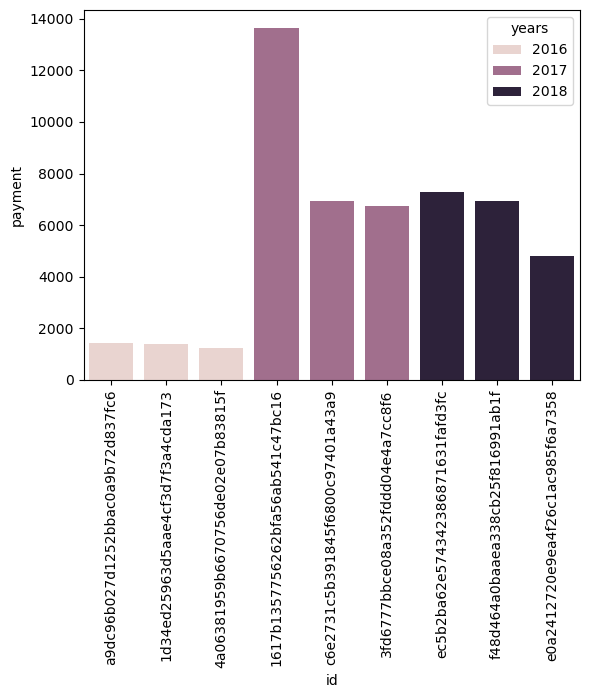

In [49]:
query = """select years, customer_id, payment, d_rank
from
(select year(orders.order_purchase_timestamp) years,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc) d_rank
from orders join payments 
on payments.order_id = orders.order_id
group by year(orders.order_purchase_timestamp),
orders.customer_id) as a
where d_rank <= 3 ;"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years","id","payment","rank"])
sns.barplot(x = "id", y = "payment", data = df, hue = "years")
plt.xticks(rotation = 90)
plt.show()

# Conclusion

The conclusions and findings are based on detailed data analysis using a variety of SQL queries, statistical insights, and visualizations, each addressing different aspects of Sale's operations in Target's company . Here's how the analysis was conducted to arrive at these findings:

# Findings:

1) Customer Demographics: Customers from large cities contribute significantly to total sales, particularly in São Paulo and Rio de Janeiro.
How: By analyzing the unique cities and states where customers are located (Basic Query 1), we identified that customers from large cities, particularly São Paulo and Rio de Janeiro, contribute significantly to total sales. Grouping customer data by city and state allowed us to observe geographic sales patterns, leading to the conclusion that metropolitan areas are key contributors.
Why: This is critical for optimizing localized marketing strategies and focusing customer engagement in high-sales areas.

   
2) Sales Trends: Orders steadily increased in 2017, and a substantial portion of orders were paid in installments.
How: We used SQL queries to count the number of orders placed in 2017 (Basic Query 2) and found a steady increase in orders during the year. Additionally, by calculating the percentage of orders paid in installments (Basic Query 4), we found that installment payments were a common option for many customers, indicating a preference for flexibility in payment methods.
Why: The increase in orders shows growing customer engagement, while the high percentage of installment payments points to a price-sensitive customer base that prefers spreading payments over time.

   
3) Product Insights: Weak Negative correlation found.  
How: We examined product sales by category (Basic Query 3) and investigated the correlation between product price and purchase frequency (Intermediate Query 4). We found that  ther eis weak negative correlation between price and purchase count. This weak correlation suggests that price is not a major factor influening how frequently a product is purchased.


Why: These insights help optimize pricing strategies and product assortment, focusing on offering the right products at the right price to maximize sales.

   
5) Retention and Growth: Retention rates highlight that a majority of customers do not make repeat purchases within 6 months, offering room for improvement.
How: We calculated customer retention rates by determining the percentage of customers who made repeat purchases within 6 months of their first purchase (Advanced Query 4). The analysis showed a relatively low retention rate, meaning that a majority of customers do not return for repeat purchases within a short period. We also examined year-over-year sales growth (Advanced Query 3) to see the overall business growth trend.
Why: Improving retention rates is crucial for sustainable growth. These findings highlight a key area for improvement in customer loyalty programs and post-purchase engagement strategies to encourage repeat purchases.



# Overall Analysis:
Methodology:
1) SQL Queries were used to retrieve and aggregate data from multiple tables (customers, orders, products, payments).
2) Pandas and Seaborn were used to generate visualizations that made trends easier to spot.
3) Statistical Measures: Moving averages, correlations, and revenue breakdowns helped reveal underlying trends in customer behavior, product sales, and payment preferences.

   
# Conclusion:
The combination of customer geography, order trends, product pricing, and customer retention data leads to actionable insights. By optimizing product pricing, focusing on key cities, and enhancing post-purchase engagement, Target Brazil can potentially increase revenue, improve customer retention, and make data-driven decisions to fuel future growth.

   
These findings help in better understanding customer behavior, optimizing product pricing strategies, and identifying potential for revenue growth.

